# HW 5 #
### Total points: 80 ###

## Name(s) and EID(s):

If you prefer, you can work in groups of two. **Please note that only one student per team needs to submit the assignment but make sure to include both students' names and UT EIDs.**  

For any question that requires a handwritten solution, you may upload scanned images of your solution in the notebook or attach them to the assignment . You may write your solution using markdown as well.

Please make sure your code runs and the graphs and figures are displayed in your notebook and PDF before submitting.

# Q1. Convolutional Neural Networks (20 points)
Answer the following questions briefly (1 paragraph should suffice):

## Part 1 (6 points)
Why are skip connections useful in CNN architectures like ResNet? (*Hint: think about gradient propagation in very deep networks*)

## Answer

## Part 2 (7 points)
How does batch normalization improve training in CNNs, and why is it generally used after a convolutional layer but before the activation function?

## Answer

## Part 3 (7 points)
Explain how the concept of translation invariance is achieved in CNNs and why it is an important property for visual recognition tasks.

## Answer

# Q2. Contrastive Learning (30 points)

### Part 1 (5 points)
Consider the example we saw in the class w.r.t Contrastive Learning (CL). We had two Cat images (say $C_1$, $C_2$) and one Bicycle image($B_1$), which we used for CL. However, if we only had one Cat image($C_1$) and one Bicycle image($B_1$), can we still do Contrastive Learning? If no, why?

If yes, how? (ie, what will be my reference sample, positive sample, and negative sample?)

Ans:
Yes, we can still do Contrastive Learning with just one Cat image (C1) and one Bicycle image (B1), but it depends on how we generate the positive and negative samples. In this case, we can use data augmentation techniques (like flipping, cropping, or changing the color slightly) to create a new version of the Cat image (C1'). The original Cat image (C1) becomes the reference sample, the augmented Cat image (C1') serves as the positive sample, since it's similar to (C1), and the Bicycle image (B1) acts as the negative sample, since it's different from (C1). This way, the model can learn to pull similar samples closer in the representation space and push dissimilar ones apart, even with a limited dataset.

### Part 2 (5 points)
We need labelled data for contrastive learning. True or False? Can you think of a real world example where contrastive learning is a better choice compared to the conventional training approach? (Caution: If you use ChatGPT to answer this question you might end up giving same example as other students)

Ans:
 False, Contrastive learning does not require labeled data because it is a self-supervised learning technique. Instead of relying on explicit labels, it uses inherent relationships within the data (e.g., augmented versions of the same image as positives and different images as negatives) to learn meaningful representations.

Contrastive learning can be particularly useful for building personalized learning systems, such as student performance prediction or recommendation systems for study materials.

For example, consider a scenario where we have a dataset of student-written essays. Instead of labeled data specifying the quality of each essay (e.g., "good" or "bad"), we can use contrastive learning to learn meaningful representations of essays. Positive pairs can be created by augmenting the same essay (e.g., paraphrasing or slightly modifying it), while negative pairs can be formed by contrasting essays from different students. This method helps the model understand nuanced differences between essays without requiring explicit labels, making it ideal for large-scale, unlabeled datasets in educational contexts.

### Part 3 (20 points)

Let us now mimic contrastive learning on a toy example to get a feeling of how it helps learn better representations for the data samples (After all, the entire Deep Learning is, in someway, learning to represent the data accurately)

We will pick the same example again. Consider three 32x32 images $C_1, C_2, B_1$. We use random values to fill the three images.

**What's more important is to ensure that C1 is more similar to C2 than B1, for the algorithm to work!**

Part 3.0 (3 points) Please initialize C1 and B1. C2 has been filled for you, which you can see, is just a slightly noisy version of C1.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random
import torchvision.transforms.functional as TF


random_seed = 16

random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

# Define sample images for cats (C1, C2) and bicycle (B1)
# Use torch randn to initialize C1 and B1

#FILLME
C1 = (torch.tensor([[0.8, 0.9, 0.7]]).repeat(32, 32, 1).permute(2, 0, 1) )* 1.2 # A "Cat" image with distinct values
C2 = C1 + 0.5 * torch.randn(3, 32, 32)  # Cat image 2, same as C1 with slight noise

#FILLME
B1 = (torch.tensor([[-0.5, -0.4, -0.6]]).repeat(32, 32, 1).permute(2, 0, 1))*1.8  # A "Bicycle" image with different values


We have provided you with an Encoder (SimpleEncoder) that generates vector representation for an input image. Note how the encoder uses Convolution to generate vector representation of an image.

Part 3.1 (2 points) Please complete the forward pass of the Encoder module

In [8]:
class SimpleEncoder(nn.Module):
    def __init__(self):
        super(SimpleEncoder, self).__init__()
        self.conv = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(16 * 16 * 16, 128)

    def forward(self, x):
        #FILLME
        x =  self.conv(x)
        x = x.view(x.size(0), -1)
        #FILLME
        x =  x.view(x.size(0), -1)
        return F.normalize(x, p=2, dim=1)

# Function for contrastive loss as in previous example
def contrastive_loss(anchor, positive, negatives, temperature=0.5):
    pos_sim = F.cosine_similarity(anchor.unsqueeze(0), positive.unsqueeze(0))
    pos_loss = -torch.log(torch.exp(pos_sim / temperature))
    neg_loss = sum(-torch.log(1 - torch.exp(F.cosine_similarity(anchor.unsqueeze(0), neg.unsqueeze(0)) / temperature))
                   for neg in negatives)
    return pos_loss + neg_loss

Part 3.2 (5 points)
Get embeddings for the images. Build the positive and negative pairs. Code for doing contrastive learning on these pairs is already given to you.

In [9]:
# Instantiate encoder and generate initial embeddings
encoder = SimpleEncoder()
images = torch.stack([C1, C2, B1])  # Stack images into a batch

#get initial_embeddings for the images using encoder
#FILLME
initial_embeddings = encoder(images).detach()
# Train encoder to minimize contrastive loss (one simple update step as an example)
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.01)

#run few passes of training (we don't want it to overfit given a single sample)
for _ in range(1):
  embeddings = encoder(images)
  #FILLME
  pos_pair = (embeddings[0], embeddings[1])  # C1 and C2 as positive pair
  neg_pair1 = (embeddings[0], embeddings[2])  # C1 and B1 as negative pair
  neg_pair2 = (embeddings[1], embeddings[2])  # C2 and B1 as negative pair

  # Contrastive loss as before
  loss1 = contrastive_loss(pos_pair[0], pos_pair[1], [neg_pair1[1]])
  loss2 = contrastive_loss(pos_pair[1], pos_pair[0], [neg_pair2[1]])
  total_loss = (loss1 + loss2) / 2

  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

encoder.eval()
with torch.no_grad():
  trained_embeddings = encoder(images).detach()

###Cosine Similarity between embeddings
The cosine similarity between embeddings would change once you run the CL algorithm. Run the below cell to observe the cosine similarities and answer the question that follows.

In [10]:
from torch.nn.functional import cosine_similarity

# Function to compute and print cosine similarities
def print_cosine_similarities(embeddings, stage=""):
    # Calculate cosine similarities
    sim_C1_C2 = cosine_similarity(embeddings[0].unsqueeze(0), embeddings[1].unsqueeze(0)).item()
    sim_C1_B1 = cosine_similarity(embeddings[0].unsqueeze(0), embeddings[2].unsqueeze(0)).item()
    sim_C2_B1 = cosine_similarity(embeddings[1].unsqueeze(0), embeddings[2].unsqueeze(0)).item()

    # Print similarities
    print(f"Cosine Similarities {stage}:")
    print(f"Similarity between C1 and C2 (positive pair): {sim_C1_C2:.4f}")
    print(f"Similarity between C1 and B1 (negative pair): {sim_C1_B1:.4f}")
    print(f"Similarity between C2 and B1 (negative pair): {sim_C2_B1:.4f}\n")

# Cosine similarities before training
print_cosine_similarities(initial_embeddings, stage="Before Contrastive Learning")

# Cosine similarities after training
print_cosine_similarities(trained_embeddings, stage="After Contrastive Learning")

Cosine Similarities Before Contrastive Learning:
Similarity between C1 and C2 (positive pair): 0.9091
Similarity between C1 and B1 (negative pair): -0.9230
Similarity between C2 and B1 (negative pair): -0.8393

Cosine Similarities After Contrastive Learning:
Similarity between C1 and C2 (positive pair): 0.9452
Similarity between C1 and B1 (negative pair): -0.9643
Similarity between C2 and B1 (negative pair): -0.9114



Part 3.3(5 points) Comment on the cosine similarities before and after the contrastive learning.

Before contrastive learning, the cosine similarities show that the positive pair (C1 and C2) already had a high similarity of 0.9091, indicating that the model was somewhat capable of recognizing their similarity. However, the negative pairs (C1 and B1, C2 and B1) had strong negative similarities (-0.9230 and -0.8393), suggesting decent separation but with room for improvement. After contrastive learning, the positive pair's similarity increased further to 0.9452, demonstrating enhanced alignment of similar data. At the same time, the negative pairs exhibited even stronger negative similarities (-0.9643 and -0.9114), indicating improved separation of dissimilar data. Overall, contrastive learning significantly strengthened the model's ability to distinguish between similar and dissimilar pairs, refining the representations.

### Plotting the embeddings
To visualize the relative change in position before and after CL, we have provided code that uses PCA to plot the embeddings on a 2-D space. Run and generate the plot and then answer the question that follows.

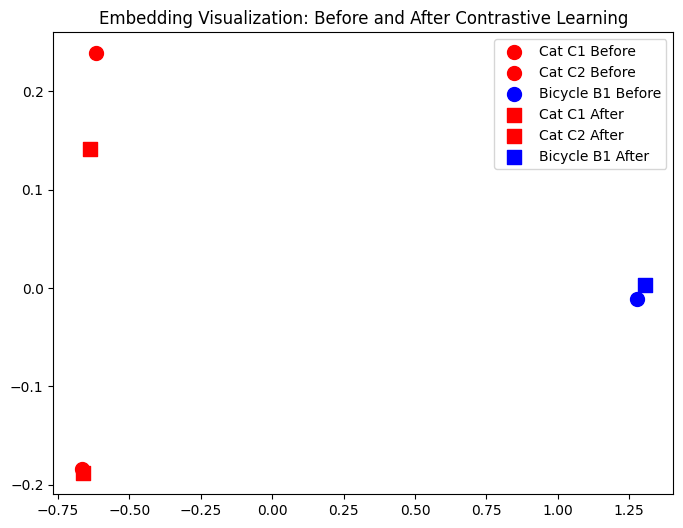

In [11]:
from sklearn.decomposition import PCA
# Function to plot embeddings using PCA
def plot_embeddings(initial_embeddings, trained_embeddings, labels):
    # Combine embeddings before and after CL
    embeddings_combined = torch.cat([initial_embeddings, trained_embeddings], dim=0).cpu().numpy()

    # Apply PCA
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings_combined)

    # Define markers and colors for before and after
    markers = ['o', 's']  # Circle for 'Before', Square for 'After'
    colors = ['red', 'red', 'blue']

    plt.figure(figsize=(8, 6))
    # Plot before contrastive learning (initial embeddings)
    for i in range(3):
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], label=f'{labels[i]} Before', color=colors[i], marker=markers[0], s=100)

    # Plot after contrastive learning (trained embeddings)
    for i in range(3, 6):
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], label=f'{labels[i-3]} After', color=colors[i-3], marker=markers[1], s=100)

    plt.title("Embedding Visualization: Before and After Contrastive Learning")
    plt.legend()
    plt.show()

# Labels for the images
labels = ["Cat C1", "Cat C2", "Bicycle B1"]

# Plot combined before and after embeddings
plot_embeddings(initial_embeddings, trained_embeddings, labels)

Part 3.4 (5 points) Comment on the above chart. Do you see the points moving around? Do they make sense to you?

The chart visualizes the embeddings of "Cat" and "Bicycle" points before and after contrastive learning. Before contrastive learning, the points for the same category (e.g., Cat C1 and Cat C2) were relatively close, but not perfectly aligned, and dissimilar points (e.g., Cat and Bicycle) were somewhat separated. After contrastive learning, the embeddings for similar pairs (e.g., Cat C1 and Cat C2) moved closer together, while the embeddings for dissimilar pairs (e.g., Cat and Bicycle) moved farther apart. This movement aligns with the goal of contrastive learning, where similar items are pulled together and dissimilar items are pushed apart in the embedding space. The visualizations confirm that the learning process improved the clustering of similar categories and the separation of different ones, which makes sense given the purpose of contrastive learning.
